<a href="https://colab.research.google.com/github/StephenScinocca/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All of the different packages used for this notebook


In [21]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler

import numpy as np
import math 
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt

import os
import copy
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map


# Functions

The following functions are called for my model, and they are:

## Setup of Model

### get_device()
  Checks to see what device (cpu or cuda) we are using

### to_device(data, device)
  Sets data to go to that device so we can use a GPU on google docs

In [22]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


## In use by Model

### convolutions(in_channel,out_channel,kernel, pad = 0) 
Takes in starting channels, the ending channels, kernel size, and padding, then does a 2d convultion followed up by batch normalization

### training (epochs, optimizer, scheduler, criterion, trainloader, validloader, net) 
Takes in all of the information needed to train the convolutional neural net and trains it over the number of epochs past into it. At the end, it outputs the trained network as net, training loss, validation loss, and valodaition accuracy, witht he last 3 being lists of each loss and accuracy after each epoch.


### accuracy(net, loader, k = 1)
Taking in a trained network and a loader (trainloader, testloader, validloader), and k which is top k accuracy. The default is k = 1, or top 1 accuracy. It prints out the accuracy of the model at the end

### validation_a_and_l(net, validloader, criterion, epoch)

Gets the validation accuracy and the validation loss, is called after training is finishe don an epoch. It prints out the loss and accuracy to the console, and also returns the values. 

### plot_losses(val_losses, losses, epochs)

Plots the loss values of training and validation each epoch

### plot_accuracy(val_accuracy, epochs)

Plots the accuracy of the validation set each epoch

In [23]:
# for each convolutional layer, does the convolution then does batch normalization
def convolutions(in_channel,out_channel,kernel, pad = 0):
  layers = [nn.Conv2d(in_channel,out_channel,kernel, padding = pad),
             nn.BatchNorm2d(out_channel)]
  return nn.Sequential(*layers)

def training (epochs, optimizer, scheduler, criterion, trainloader, validloader, net):
  # tracking the training loss per epoch
  train_losses = []
  # tracking the validation loss per epoch
  val_losses = []
  # tracking the validation accuracy per epoch
  val_accuracy = []
  for epoch in range(epochs):
      #sets the network in training mode
      net.train()
      # running loss is the loss per epoch
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          optimizer.zero_grad()
          # Gives you the outputs of each image in the batch
          outputs = net(inputs)
          # Calculates the loss of each 
          loss = criterion(outputs, labels)
          # Computes gradients for each parameter
          loss.backward()
          # Optimizer updates
          optimizer.step()
          # scheduelr updates
          scheduler.step()
          # tracks the loss of each item in the batch and adds them to running loss
          running_loss += loss.item()
          
      # prints out the training loss
      print('[{}] Training loss: {:.3f}'.format(epoch, running_loss / len(trainloader)))
      train_losses.append(running_loss / len(trainloader))
      val_l, val_a = validation_a_and_l(net, validloader, criterion, epoch)
      val_losses.append(val_l)
      val_accuracy.append(val_a)
  print("Finished Training")
  return (net, train_losses, val_losses, val_accuracy)


def accuracy(net, loader, k = 1):
  # number of correct predictions
  correct = 0
  # total number of labels (= 10000)
  total = 0
  # puts net in evaluation mode
  net.eval()
  with torch.no_grad():
    # loads in the data one batch at a time
    for data in loader:
        images, labels = data
        # outputs is the new output from running those images through the net
        outputs = net(images)
        # gets predictions from network (top k)
        _, predicted = torch.topk(outputs.data, k, dim = 1)
        # transpose the predictions
        predicted = predicted.t()
        # expand the labels to be the same length as the predictions
        labels_expanded = labels.view(1, -1).expand_as(predicted)
        # if any of the top k choices match with the label adds to correct
        topk_correct = (predicted == labels_expanded)
        # reshape topk_correct 
        topk_matched_truth = topk_correct.reshape(-1).float()
        # actually gets the number of correct lable sin the top k amount
        correct += topk_matched_truth.float().sum(dim=0, keepdim=True)
        # adds the total per batch
        total += labels.size(0)
  # prints the top k accuracy for the loader (usually testloader passed in)
  print("Top {} accuracy: {:.1f}%".format(k, 100 * int(correct) / total))


def validation_a_and_l(net, validloader, criterion, epoch):
  # number of correct predictions
  correct = 0
  # total number of labels (= 10000)
  total = 0
  # Running loss of validation
  running_loss = 0.0
  # puts net in evaluation mode
  net.eval()
  with torch.no_grad():
    # loads in the data one batch at a time
    for data in validloader:
        # gets the images and labels from that batch
        images, labels = data
        # outputs is the new output from running those images through the net
        outputs = net(images)
        # gets predictions from network (top 1)
        _, predicted = torch.max(outputs.data, 1)
        # updates the total each batch
        total += labels.size(0)
        # updates with the total number of correct predictions each batch
        correct += (predicted == labels).sum().item()
        # updated the valiadation loss each batch
        val_loss = criterion(outputs, labels)
        # updates running loss with the new valiation loss
        running_loss += val_loss
  # prints the valiadtion loss and accuracy in this epoch
  print('[{}] Validation loss: {:.3f}'.format(epoch, running_loss / len(validloader)))
  print("[{}] Accuracy of validation set: {:.1f}%".format(epoch, 100 * correct / total))
  # returns the validation loss and accuracy in this epoch
  return (running_loss / len(validloader), correct / total)

# plots the losses
def plot_losses(val_losses, train_losses, epochs):
  plt.plot(val_losses, label = "Validation")
  plt.plot(train_losses, label = "Training")
  plt.xlabel("epochs")
  plt.ylabel("Losses")
  plt.legend(title = "Losses")
  plt.title("Losses over {} epochs".format(epochs))

# plots the accuracy  
def plot_accuracy(accuracy, epochs):
  plt.plot(accuracy)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.title("Validation Accuracy over {} epochs".format(epochs))


This next section is used to find out the normalize value by finding out the mean and standard deviation of our data, so we can normalize between 0 and 1.

In [27]:
transform = T.Compose([
    T.ToTensor()
])
testset = torchvision.datasets.CIFAR100(root='./data', train = False,
                                         download = True, transform = transform)

dataloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

mean = []
std = []
for i, data in enumerate(dataloader, 0):
    # shape (batch_size, 3, height, width)
    inputs, labels = data

    numpy_image = inputs.numpy()

    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    mean.append(batch_mean)
    std.append(batch_std)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
mean = np.array(mean).mean(axis=0)
std = np.array(std).mean(axis=0)

print(mean)
print(std)

Files already downloaded and verified
[0.5066172  0.48587695 0.44015914]
[0.26701313 0.2561134  0.275536  ]


## For training data

Mean:[0.507 0.486 0.441 ]

STD: [0.256 0.246 0.265 ]

<!-- ## For test data

Mean:[0.5066172  0.48587695 0.44015914]

STD: [0.26701313 0.2561134  0.275536  ] -->

Now we do the transformations and load in the data. I transform the training set with RandomCrop with padding (mode is reflect), and randomHorizontalFlip. We also normalize with the mean and std above


In [28]:
#Transform for training
transform1 = T.Compose(
    [
    T.RandomCrop(32, padding=4,padding_mode='reflect'),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.507, 0.486, 0.441), (0.256, 0.246, 0.265))]
    )

#Transform for testing
transform2 = T.Compose(
    [
    T.ToTensor(),
    T.Normalize((0.507, 0.486, 0.441), (0.256, 0.246, 0.265))]
    )

trainset = torchvision.datasets.CIFAR100(root='./data', train = True,
                                         download = True, transform = transform1)


testset = torchvision.datasets.CIFAR100(root='./data', train = False,
                                         download = True, transform = transform2)

# Batch size for the loaders                                         
num_batches = 200

Files already downloaded and verified
Files already downloaded and verified


## Split the validation and training set equally among classes


This section shows how to use test_train_split from scikit learn to get the indices of each class in the sets, randomly scramble them with SubsetRandomSampler, and then load them in using the sample condition to get your validation set and testing set

The validation set has 100 images of each class, as does the test set. The training set has 400 images of each class

In [29]:
# Sets the device to cuda if available
device = get_device()

# print((trainset.classes))
# This gives the indices of the training set
trainset_indices = [i for i in range(len(trainset))]
# With this we can get a split of the indices of trainset to be compelety evenly split between the classes
train_indices, val_indices, train_tar, val_tar = train_test_split(trainset_indices, trainset.targets, test_size = 0.2, stratify = trainset.targets, random_state=78)
# this splits the subsets randomly for training samples
train_sampler = SubsetRandomSampler(train_indices)
# this splits the subsets randomly for validation samples
val_sampler = SubsetRandomSampler(val_indices)
#load them using dataloader, and use sampler with the indicies to know which ones have the correct split
trainloader = DataLoader(trainset, num_workers=2,pin_memory=True, shuffle=False, batch_size=num_batches, sampler=train_sampler)
validloader = DataLoader(trainset, num_workers=2,pin_memory=True, shuffle=False, batch_size=num_batches, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=num_batches, num_workers=2,pin_memory=True, shuffle=False)

# Moves the loaders to cuda from CPU
trainloader = ToDeviceLoader(trainloader,device)
validloader = ToDeviceLoader(validloader,device)
testloader = ToDeviceLoader(testloader,device)

## Model (CNN)

This model uses 5 convolutional layers and 3 fully connected layers

It uses maxpooling on two of the layers (1 and 5) with 2x2 pooling to half the size of the image. 

The number of channels was tested with different values, but I found that the model ran quite fast and got good results when I doubled the size of the number of channels each convulution

Dropout is used on the first two fully connected layers with p = 0.5, as I found that I got better results with p = 0.5 compared to 0.25 or 0, as they make the model overfit. 



In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool1 = nn.MaxPool2d(2,2)
        #    Image size is 32 x 32     
        self.conv1 = convolutions(3,16,5)
        #    Image size is 14 x 14 
        self.conv2 = convolutions(16,32,3, pad = 1)
        #    Image size is 14 x 14
        self.conv3 = convolutions(32,64,3)
        #    Image size is 12 x 12
        self.conv4 = convolutions(64,128,3, pad = 1)
        #    Image size is 12 x 12
        self.conv5 = convolutions(128,256,3)
        #    Image size is 5 x 5        
        self.fc1 = nn.Linear(256*5*5, 1500)
        self.fc2 = nn.Linear(1500, 1000)
        self.fc3 = nn.Linear(1000,100)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        #    Image size is 32 x 32
        x = self.pool1(F.relu(self.conv1(x)))
        #    Image size is 14 x 14
        x = F.relu(self.conv2(x))
        #    Image size is 14 x 14
        x = F.relu(self.conv3(x))
        #    Image size is 12 x 12
        x = F.relu(self.conv4(x))
        #    Image size is 12 x 12
        x = self.pool1(F.relu(self.conv5(x)))
        #    Image size is 5 x 5

        # Flattem makes everything into a single long array
        x = torch.flatten(x, 1)
        # Relu used on a fully connected layer fc1
        x = F.relu(self.fc1(x))
        # dropout with p = 0.5
        x = self.dropout(x)
        # Relu used on a fully connected layer fc2
        x = F.relu(self.fc2(x))
        # dropout with p = 0.5
        x = self.dropout(x)
        # fully connected layer fc3
        x = self.fc3(x)
        return x

net = CNN()
net = to_device(net,device) 

In [32]:
# total number of epochs
epochs = 75

# Criterion is the loss function we use for our neural net
# Cross Entropy Loss is good because it can act like softmax, where the bigger value is a more likely choice to be played
criterion = nn.CrossEntropyLoss()
# The optimizer is used 
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
# The scheduler decides the learning rate for each batch, so it can change throught the training process
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs = epochs, steps_per_epoch=len(trainloader))


Train the model using training! 

In [33]:
net, train_losses, val_losses, val_accuracy = training(epochs, optimizer, scheduler, criterion, trainloader, validloader, net)

[0] Training loss: 4.585
[0] Validation loss: 4.499
[0] Accuracy of validation set: 3.0%
[1] Training loss: 4.453
[1] Validation loss: 4.318
[1] Accuracy of validation set: 6.2%
[2] Training loss: 4.255
[2] Validation loss: 4.053
[2] Accuracy of validation set: 9.0%
[3] Training loss: 4.038
[3] Validation loss: 3.827
[3] Accuracy of validation set: 11.8%
[4] Training loss: 3.839
[4] Validation loss: 3.653
[4] Accuracy of validation set: 13.9%
[5] Training loss: 3.666
[5] Validation loss: 3.551
[5] Accuracy of validation set: 15.1%
[6] Training loss: 3.509
[6] Validation loss: 3.300
[6] Accuracy of validation set: 19.3%
[7] Training loss: 3.351
[7] Validation loss: 3.230
[7] Accuracy of validation set: 20.8%
[8] Training loss: 3.216
[8] Validation loss: 3.150
[8] Accuracy of validation set: 21.8%
[9] Training loss: 3.100
[9] Validation loss: 2.928
[9] Accuracy of validation set: 26.4%
[10] Training loss: 2.961
[10] Validation loss: 2.956
[10] Accuracy of validation set: 26.0%
[11] Train

This part here checks the top 1 and top 5 accuracy for the model on the testset 

In [34]:
accuracy(net, testloader, k = 1)
accuracy(net, testloader, k = 5)

# accuracy(net, trainloader, k = 1)
# accuracy(net, trainloader, k = 5)


Top 1 accuracy: 60.9%
Top 5 accuracy: 86.8%


Here we plot the loss of the training and validation each epoch

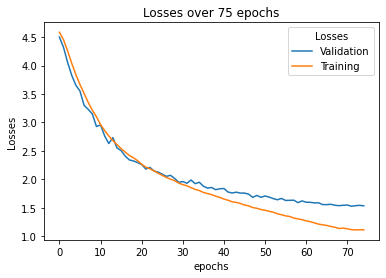

In [35]:
plot_losses(val_losses, train_losses, epochs)

And here we plot the accuracy of the validation set each epoch

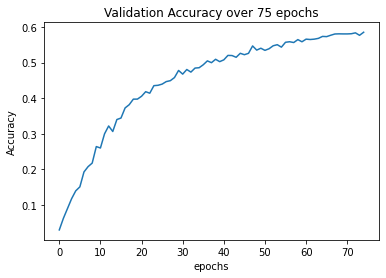

In [36]:
plot_accuracy(val_accuracy, epochs)

This code under here is used for finding the best learning rate, best scheduler, best number of batches, and more. It was edited each time I needed to see which test to run. The one it is currently looking at is learning_rates, and the code underneath is for visualizing all of the different results put together. 

In [14]:
# number of epochs
epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.1, momentum = 0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs = epochs, steps_per_epoch=len(trainloader))

# Different learning rates tried
# learning_rates = [0.001, 0.01, 0.05, 0.1]
learning_rates = [0.001, 0.01, 0.05]

# Stores all of the different types of losses of each net in each round
train_losses = np.zeros([len(learning_rates),epochs])
val_losses = np.zeros([len(learning_rates),epochs])
val_acc = np.zeros([len(learning_rates),epochs])
nets = []

for i in range(len(learning_rates)):
  testnet = CNN()
  testnet = to_device(testnet,device)

  optimizer = optim.SGD(testnet.parameters(), lr = learning_rates[i], momentum = 0.9)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rates[i], epochs = epochs, steps_per_epoch=len(trainloader))
  n, train_losses[i], val_losses[i], val_acc[i] = training(epochs, optimizer, scheduler, criterion, trainloader, validloader, testnet)
  nets.append(n)
 


[0] Training loss: 4.618
[0] Validation loss: 4.586
[0] Accuracy of validation set: 1.8%
[1] Training loss: 4.566
[1] Validation loss: 4.493
[1] Accuracy of validation set: 3.5%
[2] Training loss: 4.476
[2] Validation loss: 4.389
[2] Accuracy of validation set: 6.0%
[3] Training loss: 4.370
[3] Validation loss: 4.231
[3] Accuracy of validation set: 6.3%
[4] Training loss: 4.237
[4] Validation loss: 4.090
[4] Accuracy of validation set: 9.0%
[5] Training loss: 4.123
[5] Validation loss: 3.976
[5] Accuracy of validation set: 10.4%
[6] Training loss: 4.038
[6] Validation loss: 3.881
[6] Accuracy of validation set: 11.5%
[7] Training loss: 3.960
[7] Validation loss: 3.821
[7] Accuracy of validation set: 12.9%
[8] Training loss: 3.918
[8] Validation loss: 3.786
[8] Accuracy of validation set: 13.0%
[9] Training loss: 3.897
[9] Validation loss: 3.788
[9] Accuracy of validation set: 13.0%
Finished Training
[0] Training loss: 4.551
[0] Validation loss: 4.346
[0] Accuracy of validation set: 4.2

This next block prints the top1 and top5 accuracy of each net trained above

In [15]:
for net in nets:
  accuracy(net, testloader, k = 1)
  accuracy(net, testloader, k = 5)

Top 1 accuracy: 14.2%
Top 5 accuracy: 36.7%
Top 1 accuracy: 37.8%
Top 5 accuracy: 69.5%
Top 1 accuracy: 42.2%
Top 5 accuracy: 74.2%


This plots all of the training and validation loss of each trained CNN onto one graph for easy visualization. It was left on batches, as that was the last one it was used on. 

Text(0.5, 1.0, 'Different Learning Rates Loss')

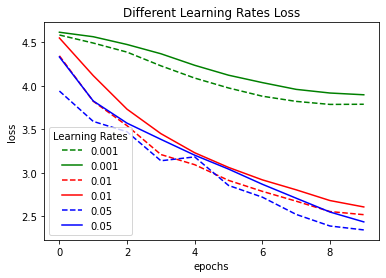

In [16]:
colours = ['g', 'r', 'b', 'c']
for i in range(len(learning_rates)):
  plt.plot(val_losses[i], '{}--'.format(colours[i]), label = learning_rates[i])
  plt.plot(train_losses[i], '{}-'.format(colours[i]), label = learning_rates[i])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(title = "Learning Rates")
plt.title("Different Learning Rates Loss")

# Visualization (Bonus)

This code is needed for creating new images based on each class. This is done by using stochastic gradient ascent, where you start with a bunch of randomly assigned pixel values and then train with your model to make that look like a specific class. 

## Functions

These are the functions needed to generate the images. The original code can be found here: https://github.com/utkuozbulak/pytorch-cnn-visualizations, but here it has been altered and changed to work on smaller images, and updated to new not use depreciated methods and objects (Mostly variables, and a couple other things.)

### format_np_output(np_arr) 

This takes in a numpy array, and then converts it to have the same output which is 3 x W x H, or for CIFAR100, 3 x 32 x 32

### save_image(im,path)

This saves the image im to a path which specifies the name and what folder it will be saved in. 

### preprocess_image(pil_im, resize_im = True)

preprocess images takes in an image in the form of PIL (Pythong Imaging Library), and outputs the images as a tensor, and with the corrections needed to the mean and std so that it will be a value withing the range of [-1,1]. 

### recreate_image(im_as_ten)

Takes a tensor of an image, and then puts in back into its original form so it can be saved as an image and repassed in as the new image for the stochasitic gradient ascent

## Class: ClassSpecificImageGeneration

This class is used to generate a new image for a specific class listed when you create the object. It has one method, generate(), which actually generates the image. 

### generate()


In [37]:
def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)

def preprocess_image(pil_im, resize_im=True):
    
    # mean and std list for channels 
    mean = [0.50695723, 0.48641145, 0.4407998 ]
    std = [0.25612617, 0.24619192, 0.2645457 ]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((32, 32), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_arr = np.expand_dims(im_as_arr, axis=0)
    im_as_ten = torch.tensor(im_as_arr, requires_grad=True, device="cuda").float()
    

    im_as_ten = to_device(im_as_ten,device) 
    return im_as_ten

def recreate_image(im_as_ten):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_ten (torch tensor): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.50695723, -0.48641145, -0.4407998 ]
    reverse_std = [1/0.25612617, 1/0.24619192, 1/0.2645457]
    im_as_ten = im_as_ten.cpu()
    recreated_im = copy.copy(im_as_ten.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


class ClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent
    """
    def __init__(self, model, target_class):
        self.mean = [-0.50695723, -0.48641145, -0.4407998 ]
        self.std = [1/0.25612617, 1/0.24619192, 1/0.2645457]
        self.model = model
        self.model = to_device(model,device) 
        self.model.eval()
        self.target_class = target_class
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(0, 255, (32, 32, 3)))
        # Create the folder to export images if not exists
        if not os.path.exists('/content/generated/class_'+str(self.target_class)):
            os.makedirs('/content/generated/class_'+str(self.target_class))

    def generate(self, iterations=150):
        """Generates class specific image
        Keyword Arguments:
            iterations {int} -- Total iterations for gradient ascent (default: {150})
        Returns:
            np.ndarray -- Final maximally activated class image
        """
        criterion = nn.CrossEntropyLoss()
        learning_rates = [6, 0.6]
        for i in range(1, iterations):
            learning_rate = learning_rates[int(i/(iterations/len(learning_rates)))]
            # Process image and return variable
            self.processed_image = preprocess_image(self.created_image, False)
            # Define optimizer for the image
            optimizer = optim.SGD([self.processed_image], lr=learning_rate)
           
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]
            # class_loss = -1 * criterion(output, torch.uint8(self.target_class))

            if i % (iterations/10) == 0 or i == iterations-1:
                cl = class_loss.cpu()
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(cl.data.numpy()))
            # Zero grads
            self.model.zero_grad()

            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            optimizer.zero_grad()

            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            if i == iterations-1:
                # Save image
                im_path = '/content/generated/class_'+str(self.target_class)+'/c_'+str(self.target_class)+'_'+'iter_'+str(i)+'.png'
                save_image(self.created_image, im_path)

        return self.processed_image


Here we run our code to generate new images, and it outputs the loss by iteration, , what the image is supposed to be, and then feeds it back into the network, and shows it predicts the same class as the chosen one. 

This example here the target class is a worm, which is class 99

In [40]:
target_class = 99  # Worm
print(trainset.classes[target_class]) # outputs class name
csig = ClassSpecificImageGeneration(net, target_class) # Creates ClassSpecificImageGeneration object
new_image = csig.generate(iterations = 300) # creates a new image based from generate and saves image to /content/generated

output = net(new_image) # runs the newly generated image through the net again
value, predicted = torch.max(output.data, 1) # predicts the class
print(predicted) #prints the predicted class


worm
Iteration: 30 Loss -80.99
Iteration: 60 Loss -87.88
Iteration: 90 Loss -89.27
Iteration: 120 Loss -90.91
Iteration: 150 Loss -88.14
Iteration: 180 Loss -129.39
Iteration: 210 Loss -131.89
Iteration: 240 Loss -132.94
Iteration: 270 Loss -133.72
Iteration: 299 Loss -134.52
tensor([99], device='cuda:0')
